### Objective : 
#### To apply k-NN (K-Nearest Neighbors algorithm) on Amazon food reviews dataset for each of the                                    featurization           below : 
                  1. Bag Of Words (BoW)
                  2. TermFrequency-InverseDocumentFrequency (TF-IDF)
                  3. Avg-Word2Vec
                  4. TFIDF-Word2Vec
                  
#### To determine the sentiment polarity, i,e.  Given a food review text, predict whether the score is Positive or Negative.
#### NOTE :
    1. Use kd-tree
    2. Use timeseries based splitting (TBS) to split the dataset into Train (70%) and Test (30%) .
    3. Apply 5-fold cross validation to find optimal 'k' in k-NN .
    4. Compute and report the test accuracy for all the 4 type of vectorization mentioned above.
    5. Sample size = 100K data points.

#### Load the Pre-processed Amazon Reviews Dataset.

In [7]:
# Copy the final cleaned text to csv file for resuse later.
#final.to_csv('finalCleanedText.csv')

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tqdm

from tqdm import tqdm # for displaying progress bar.

import pickle

import nltk
nltk.download('stopwords')


You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to C:\Users\Vijay
[nltk_data]     Joseph\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Load the pre-processed Amazon food review dataset.
final = pd.read_csv("finalCleanedText.csv")

#### Apply Time Based Sorting (TBS).

In [3]:
# Add a new column for TimeStamp that is of Datetime datatype, since the dataset's time column is of 
# integer datatype.
import datetime

final_timesplit_10000    = final['Time']
final_timesplit_10000    = final_timesplit_10000.apply(datetime.datetime.fromtimestamp)
final['TimeSplit']       = final_timesplit_10000
final_dataset            = final.sort_values(['TimeSplit'],ascending=False)

In [21]:
#final_dataset[:1000]

#### Sample the first 100K points based on time based sorting

In [5]:
#Sample first 100K points after time based sorting
final_10000 = final_dataset[:100000]
# Store label info separately.
label_10000 = final_10000['Score'][:100000]


In [6]:
print(final_10000.shape)
print(label_10000.shape)

(100000, 13)
(100000,)


In [7]:
print(label_10000[:5])
Y_1 = final_10000['Score'].map({"positive":1,"negative":0})
print(Y_1[:5])

262240    positive
33119     positive
353804    negative
328939    negative
296377    positive
Name: Score, dtype: object
262240    1
33119     1
353804    0
328939    0
296377    1
Name: Score, dtype: int64


#### Use TimeSeriesSplit to split the time based sorted Amazon food reviews dataset into Train and Test. 

In [8]:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=10)
X = final_10000['CleanedText']
Y = final_10000['Score']
Y_1 = final_10000['Score'].map({"positive":1,"negative":0})

for train_index, test_index in splits.split(X):
    X_train, X_test = X[X.index[train_index]], X[X.index[test_index]]
    y_train, y_test = Y_1[Y_1.index[train_index]], Y_1[Y_1.index[test_index]]


### Vectorization Method : Bag Of Words (BoW)

#### Convert reviews present in trainingset into numeric vectors using Bag Of Words (BoW)

In [9]:
#BoW

# Apply BoW vectorization only on the trainingset.
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn bi-gram

#Train you countvectorizer on the train data (.fit_transform()) and 
#use the same countvectorizer on the test set as well (.transform())
final_counts = count_vect.fit_transform(X_train.values.astype('U'))
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (90910, 1167986)
the number of unique words  1167986


#### Use the BoW vectorizer trained in the preceding step to convert test set to vectors.

In [10]:
#use the same countvectorizer on the test set (.transform())
final_counts_testset = count_vect.transform(X_test.values)
print("the type of count vectorizer ",type(final_counts_testset))
print("the shape of out text BOW vectorizer ",final_counts_testset.get_shape())
print("the number of unique words ", final_counts_testset.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9090, 1167986)
the number of unique words  1167986


#### Reduce Dimensions using TruncatedSVD.

In [11]:
# Reduce the dimensions of the text vectors to 100 from 190K.
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
# Training
finalTransData = svd.fit_transform(final_counts)
# Testing
finalTransDataTest = svd.transform(final_counts_testset)

In [17]:
#svd.explained_variance_ratio_

In [12]:
finalTransData.shape

(90910, 100)

In [13]:
finalTransDataTest.shape

(9090, 100)

#### Standardize Data

In [14]:
# Data-preprocessing: Normalizing the data

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

#Standardize on the train data (.fit_transform()) and 
#use the same Normalizer on the test set as well (.transform())
X_train_stdzd = normalizer.fit_transform(finalTransData)
X_test_stdzd  = normalizer.transform(finalTransDataTest) 

#### Using kd-tree method to calculate the optimal 'k' of k-NN in BoW case.

In [15]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

#GridSearchCV( cv=10,
#              error_score='raise', 
#              estimator=KNeighborsClassifier( algorithm='auto', leaf_size=30, metric='minkowski', 
#                                              metric_params=None, n_jobs=1,
#                                              n_neighbors=5, p=2, weights='uniform'), 
#              fit_params={},
#              iid=True, n_jobs=1, 
#              param_grid={'n_neighbors': array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
#                                                11, 12, 13, 14, 15, 16, 17, 18, 19, 20])}, 
#              pre_dispatch='2*n_jobs', 
#              refit=True,
#              scoring=None,
#              verbose=0
#            )

starttime_knn_bow = datetime.datetime.now()

n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tuned_parameters = [{'n_neighbors': n_neighbors,'weights': ['uniform'],'algorithm': ['kd_tree']}]
scores = ['f1']

performances = [];
for score in scores:
    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train_stdzd, y_train)

endtime_knn_bow = datetime.datetime.now()

print("Starttime is : {}".format(starttime_knn_bow))
print("Endtime   is : {}".format(endtime_knn_bow))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Starttime is : 2018-10-26 07:00:00.198573
Endtime   is : 2018-10-26 13:08:30.857578


In [16]:
print("Trainingset X: {}".format(len(X_train_stdzd)))
print("Testset     X: {}".format(len(X_test_stdzd)))
print("Trainingset Y: {}".format(len(y_train)))
print("Testset     Y: {}".format(len(y_test)))


Trainingset X: 90910
Testset     X: 9090
Trainingset Y: 90910
Testset     Y: 9090


In [17]:
# The best_params_ and best_score_ attributes on your GridSearchCV instance will give you the best 
# parameter setting found while doing grid search across parameters and its corresponding score,
# averaged across all folds.
# If you definitely need the individual fold scores, you can also iterate through the 
# grid_scores_ attribute to find the cv_validation_scores,
# which is the list of scores for each fold on that parameter setting. 

# Tabulate the CVScores.
import pandas as pd

rows = list()
for grid_score in clf.grid_scores_:
    for fold, score in enumerate(grid_score.cv_validation_scores):
        row = grid_score.parameters.copy()
        row['fold'] = fold
        row['score'] = score
        rows.append(row)
dfScore = pd.DataFrame(rows)

In [18]:
optimised_knn = clf.best_estimator_
optimised_score = clf.best_score_

print("The best estimator for the CV training set is :")
print('    The optimal number of neighbors (KD-tree case) is %d.' % optimised_knn.n_neighbors)
print("    The score for the optimal number of neighbors {} (KD-tree case) is {}.".format(optimised_knn.n_neighbors,optimised_score))


The best estimator for the CV training set is :
    The optimal number of neighbors (KD-tree case) is 9.
    The score for the optimal number of neighbors 9 (KD-tree case) is 0.9065835539358188.


#### Using kd-tree method to calculate the metrics of k-NN in BoW case.

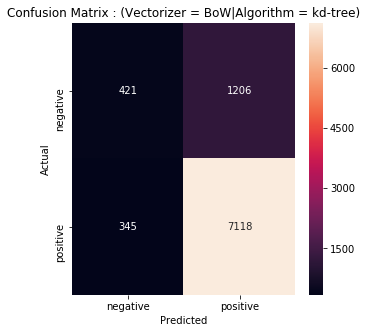

Starttime : 2018-10-26 13:19:10.100644
Endtime   : 2018-10-26 13:22:24.616927


In [20]:
# ============================== KNN with k = optimal_k ===============================================

# training features   = X_train_stdzd
# testing features    = X_test_stdzd
# training classlabel = y_train
# testing  classlabel = y_test

starttime_knn_bow = datetime.datetime.now()

# instantiate the k-nn learning model with neighbours k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimised_knn.n_neighbors)

# fitting the model
knn_optimal.fit(X_train_stdzd, y_train)

# predict the response
y_pred = knn_optimal.predict(X_test_stdzd)

# evaluate the model and report the metrics.
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d'
            ,xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title('Confusion Matrix : (Vectorizer = BoW|Algorithm = kd-tree)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

endtime_knn_bow = datetime.datetime.now()

print("Starttime : {}".format(starttime_knn_bow))
print("Endtime   : {}".format(endtime_knn_bow))

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True  Positives = {}".format(tp))
print("True  Negatives = {}".format(tn))
print("False Positives = {}".format(fp))
print("False Negatives = {}".format(fn))


True  Positives = 7118
True  Negatives = 421
False Positives = 1206
False Negatives = 345


### Vectorization Method : TermFrequency-InverseDocumentFrequency (TF_IDF)

#### Convert review text into numeric vectors using TF_IDF

In [22]:
#TF-IDF
# Apply TF-IDF vectorization only on the trainingset.
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

In [23]:
#Train you tf-idf vectorizer on the train data (.fit_transform()) and 
#use the same vectorizer on the test set as well (.transform())
final_tf_idf = tf_idf_vect.fit_transform(X_train.values.astype('U'))

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (90910, 1167986)
the number of unique words including both unigrams and bigrams  1167986


In [24]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[63600:63610])

some sample features(unique words in the corpus) ['awhil want', 'awhil wasnt', 'awhil way', 'awhil week', 'awhil weird', 'awhil would', 'awhil year', 'awhil yes', 'awhil youd', 'awhil your']


#### Use the TF-IDF vectorizer trained in the preceding step to convert test set to vectors.

In [25]:
#use the same countvectorizer on the test set (.transform())
final_tf_idf_testset = tf_idf_vect.transform(X_test.values)
print("the type of count vectorizer ",type(final_tf_idf_testset))
print("the shape of out text BOW vectorizer ",final_tf_idf_testset.get_shape())
print("the number of unique words ", final_tf_idf_testset.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9090, 1167986)
the number of unique words  1167986


#### Reduce Dimensions using TruncatedSVD.

In [26]:
# Reduce the dimensions of the text vectors to 100 from 1 Million.
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)

# Training
finalTransData = svd.fit_transform(final_tf_idf) 
# Testing
finalTransDataTest = svd.transform(final_tf_idf_testset) 

In [28]:
#svd.explained_variance_ratio_

#### Standardize / Normalize the data

In [29]:
# Data-preprocessing: Normalizing the data
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

#Standardize on the train data (.fit_transform()) and 
#use the same Normalizer on the test set as well (.transform())
X_train_stdzd = normalizer.fit_transform(finalTransData)
X_test_stdzd  = normalizer.transform(finalTransDataTest) 


#### Using kd-tree method to calculate the optimal 'k' of k-NN in TF-IDF case.

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

starttime_knn_tfidf = datetime.datetime.now()

n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tuned_parameters = [{'n_neighbors': n_neighbors,'weights': ['uniform'],'algorithm': ['kd_tree']}]
scores = ['f1']

performances = [];
for score in scores:
    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train_stdzd, y_train)

endtime_knn_tfidf = datetime.datetime.now()

print("Starttime is : {}".format(starttime_knn_tfidf))
print("Endtime   is : {}".format(endtime_knn_tfidf))


Starttime is : 2018-10-26 13:53:59.385894
Endtime   is : 2018-10-26 20:22:54.626239


In [31]:
print("Trainingset X: {}".format(len(X_train_stdzd)))
print("Testset     X: {}".format(len(X_test_stdzd)))
print("Trainingset Y: {}".format(len(y_train)))
print("Testset     Y: {}".format(len(y_test)))

Trainingset X: 90910
Testset     X: 9090
Trainingset Y: 90910
Testset     Y: 9090


In [32]:
# The best_params_ and best_score_ attributes on your GridSearchCV instance will give you the best 
# parameter setting found while doing grid search across parameters and its corresponding score,
# averaged across all folds.
# If you definitely need the individual fold scores, you can also iterate through the 
# grid_scores_ attribute to find the cv_validation_scores, which is the list of scores
# for each fold on that parameter setting. 

# Tabulate the CVScores.
import pandas as pd

rows = list()
for grid_score in clf.grid_scores_:
    for fold, score in enumerate(grid_score.cv_validation_scores):
        row = grid_score.parameters.copy()
        row['fold'] = fold
        row['score'] = score
        rows.append(row)
dfScore = pd.DataFrame(rows)

In [23]:
#dfScore

In [33]:
#Best Parameters and Best Score

optimised_knn = clf.best_estimator_
optimised_score = clf.best_score_

print("The best estimator for the CV training set is :")
print('    The optimal number of neighbors (kd-tree case) is %d.' % optimised_knn.n_neighbors)
print("    The score for the optimal number of neighbors {} (kd-tree case) is {}.".format(optimised_knn.n_neighbors,optimised_score))


The best estimator for the CV training set is :
    The optimal number of neighbors (kd-tree case) is 9.
    The score for the optimal number of neighbors 9 (kd-tree case) is 0.9139124080844796.


#### Using kd-tree method to calculate the metrics of k-NN in TF-IDF case.

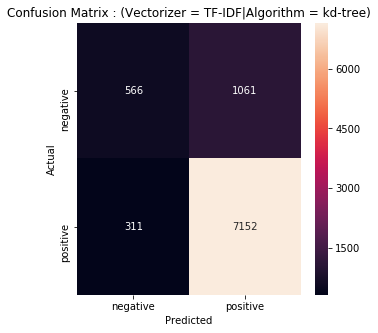

Starttime : 2018-10-26 20:29:12.272685
Endtime   : 2018-10-26 20:32:21.653243


In [34]:
# ============================== KNN with k = optimal_k ===============================================

# training features   = X_train_stdzd
# testing features    = X_test_stdzd
# training classlabel = y_train
# testing  classlabel = y_test

starttime_knn_tfidf = datetime.datetime.now()

# instantiate the k-nn learning model with neighbours k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimised_knn.n_neighbors)

# fitting the model
knn_optimal.fit(X_train_stdzd, y_train)

# predict the response
y_pred = knn_optimal.predict(X_test_stdzd)

# evaluate the model and report the metrics.
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d'
            ,xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title('Confusion Matrix : (Vectorizer = TF-IDF|Algorithm = kd-tree)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

endtime_knn_tfidf = datetime.datetime.now()

print("Starttime : {}".format(starttime_knn_tfidf))
print("Endtime   : {}".format(endtime_knn_tfidf))


In [35]:
# Metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True  Positives = {}".format(tp))
print("True  Negatives = {}".format(tn))
print("False Positives = {}".format(fp))
print("False Negatives = {}".format(fn))

True  Positives = 7152
True  Negatives = 566
False Positives = 1061
False Negatives = 311


### Vectorization Method : Average Word2Vec : Avg W2V
#### Convert review text into numeric vectors using Avg W2V

In [36]:
# Train your own Word2Vec model using your own text training corpus.
# Train Word2Vec on training set alone.
i=0
list_of_sent=[]
for sent in X_train.values.astype('U'):
    list_of_sent.append(sent.split())

In [37]:
print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent[0])

big lover fig jam fig jam uniqu flavor kind mix light kadoda fig dark mission fig must tri
*****************************************************************
['big', 'lover', 'fig', 'jam', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'kadoda', 'fig', 'dark', 'mission', 'fig', 'must', 'tri']


In [38]:
print(len(list_of_sent))
print(list_of_sent[:2])

90910
[['big', 'lover', 'fig', 'jam', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'kadoda', 'fig', 'dark', 'mission', 'fig', 'must', 'tri'], ['great', 'product', 'good', 'price', 'definit', 'order', 'product', 'use', 'bottl', 'empti']]


#### Train the Word2Vec model on the training set alone.

In [39]:
# min_count = 5 considers only words that occured atleast 5 times
# Word2Vec(list,word_repeat_count,dimension_of_each_word_vector,Number_of_Processor_cores)
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [40]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11922
sample words  ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'mission', 'must', 'tri', 'great', 'product', 'good', 'price', 'definit', 'order', 'use', 'bottl', 'empti', 'expect', 'box', 'full', 'fortun', 'cooki', 'like', 'one', 'nonetheless', 'got', 'small', 'tast', 'weird', 'okay', 'best', 'ever', 'review', 'amazon', 'check', 'label', 'contain', 'sure', 'enough', 'propylen', 'glycol', 'top', 'ingredi', 'ive', 'done']


In [42]:
print(w2v_model.wv['product'])

[ 1.8868073   1.2342165   0.40828872  0.44571272  0.5718058  -0.5033772
  0.72491133 -0.8481341  -0.26196787  0.43213588  1.0003654  -0.27913013
  1.1925273  -0.44632247  0.9911834   0.9345218   1.2784483   2.090052
 -0.49930495  0.56731564  0.7958272  -0.64167696 -0.3741146  -0.8392478
  0.12612788 -0.79930234  1.1591488  -1.2256109   0.967032   -0.48931566
  1.3194371  -0.0142371   1.9598877   0.7765498   0.19469143  0.9802186
  2.632308    0.625505    0.13893296 -1.3168555   2.5145383  -0.13013667
 -0.7779726  -1.4738183   0.7367316  -0.01612894 -0.6919018   0.43859828
  1.1478654   0.01312193]


#### Compute the average Word2Vec for each review in the training set.

In [43]:
# average Word2Vec
# Avg. Word2Vec = (W2V(w1)+W2V(w2)+W2V(w3)+...... +W2V(w364171)) / 364171
# compute average word2vec for each review.
sent_vectors = [];                     # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent:              # for each review/sentence in the training set
    sent_vec = np.zeros(50)            # as word vectors are of zero length
    cnt_words =0;                      # num of words with a valid vector in the sentence/review
    for word in sent:                  # for each word in a review/sentence
        if word in w2v_words:          # if the word exists in the vocabulary
            vec = w2v_model.wv[word]   # convert the word to vector
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print('The total number of words is {}'.format(len(sent_vectors)))
print('The dimension of each word vector is {}'.format(len(sent_vectors[0])))

The total number of words is 90910
The dimension of each word vector is 50


#### Build the text corpus of the test set.

In [44]:
# Build the test text corpus.
i=0
list_of_sent_test=[]
#for sent in final_dataset['CleanedText'].values:
for sent in X_test.values:
    list_of_sent_test.append(sent.split())

In [45]:
print(X_test.values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

mild definit coconut flavor use instead butter toast vegi rice cake etc good fri except egg crispi brown contain medium chain amino acid work wonder brain neuron connect alshiem wean babi lack may even factor caus autism oliv oil none
*****************************************************************
['mild', 'definit', 'coconut', 'flavor', 'use', 'instead', 'butter', 'toast', 'vegi', 'rice', 'cake', 'etc', 'good', 'fri', 'except', 'egg', 'crispi', 'brown', 'contain', 'medium', 'chain', 'amino', 'acid', 'work', 'wonder', 'brain', 'neuron', 'connect', 'alshiem', 'wean', 'babi', 'lack', 'may', 'even', 'factor', 'caus', 'autism', 'oliv', 'oil', 'none']


#### Use the trained word2vec model to compute the average Word2Vec for each review in the test set.

In [46]:
# average Word2Vec
# Avg. Word2Vec = (W2V(w1)+W2V(w2)+W2V(w3)+...... +W2V(w364171)) / 364171
# compute average word2vec for each review.
sent_vectors_test = [];                # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test:         # for each review/sentence in the test set
    sent_vec = np.zeros(50)            # as word vectors are of zero length
    cnt_words =0;                      # num of words with a valid vector in the sentence/review
    for word in sent:                  # for each word in a review/sentence
        if word in w2v_words:          # if the word exists in the vocabulary
            vec = w2v_model.wv[word]   # convert the word to vector using the trained model.
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print('The total number of words is {}'.format(len(sent_vectors_test)))
print('The dimension of each word vector is {}'.format(len(sent_vectors_test[0])))

The total number of words is 9090
The dimension of each word vector is 50


#### Standardize / Normalize the data

In [47]:
# Data-preprocessing: Normalizing the data
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

#Standardize on the train data (.fit_transform()) and 
#use the same Normalizer on the test set as well (.transform())
X_train_stdzd = normalizer.fit_transform(sent_vectors)
X_test_stdzd  = normalizer.transform(sent_vectors_test) 


#### Using kd-tree method to calculate the optimal 'k' of k-NN in Avg-Word2Vec case.

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

starttime_knn_tfidf = datetime.datetime.now()

n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tuned_parameters = [{'n_neighbors': n_neighbors,'weights': ['uniform'],'algorithm': ['kd_tree']}]
scores = ['f1']

performances = [];
for score in scores:
    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train_stdzd, y_train)

endtime_knn_tfidf = datetime.datetime.now()

print("Starttime is : {}".format(starttime_knn_tfidf))
print("Endtime   is : {}".format(endtime_knn_tfidf))


Starttime is : 2018-10-26 20:38:55.261909
Endtime   is : 2018-10-27 07:40:18.829428


In [49]:
print("Trainingset X: {}".format(len(X_train_stdzd)))
print("Testset     X: {}".format(len(X_test_stdzd)))
print("Trainingset Y: {}".format(len(y_train)))
print("Testset     Y: {}".format(len(y_test)))


Trainingset X: 90910
Testset     X: 9090
Trainingset Y: 90910
Testset     Y: 9090


In [50]:
# The best_params_ and best_score_ attributes on your GridSearchCV instance will give you the best 
# parameter setting found while doing grid search across parameters and its corresponding score,
# averaged across all folds.
# If you definitely need the individual fold scores, you can also iterate through the
# grid_scores_ attribute to find the cv_validation_scores, 
# which is the list of scores for each fold on that parameter setting. 

# Tabulate the CVScores.
import pandas as pd

rows = list()
for grid_score in clf.grid_scores_:
    for fold, score in enumerate(grid_score.cv_validation_scores):
        row = grid_score.parameters.copy()
        row['fold'] = fold
        row['score'] = score
        rows.append(row)
dfScore = pd.DataFrame(rows)

In [51]:
#Best Parameters and Best Score
optimised_knn = clf.best_estimator_
optimised_score = clf.best_score_

print("The best estimator for the CV training set is :")
print('    The optimal number of neighbors (kd-tree case) is %d.' % optimised_knn.n_neighbors)
print("    The score for the optimal number of neighbors {} (kd-tree case) is {}.".format(optimised_knn.n_neighbors,optimised_score))


The best estimator for the CV training set is :
    The optimal number of neighbors (kd-tree case) is 10.
    The score for the optimal number of neighbors 10 (kd-tree case) is 0.9275843253393202.


#### Using kd-tree method to calculate the accuracy of k-NN in Avg Word2Vec case.

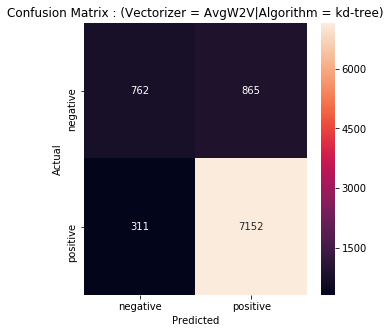

Starttime : 2018-10-27 08:18:59.650786
Endtime   : 2018-10-27 08:20:58.545020


In [52]:
# ============================== KNN with k = optimal_k ===============================================

# training features   = X_train_stdzd_dense
# testing features    = X_test_stdzd_dense
# training classlabel = y_train
# testing  classlabel = y_test

starttime_knn_avgw2v = datetime.datetime.now()

# instantiate the k-nn learning model with neighbours k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimised_knn.n_neighbors)

# fitting the model
knn_optimal.fit(X_train_stdzd, y_train)

# predict the response
y_pred = knn_optimal.predict(X_test_stdzd)

# evaluate the model and report the metrics.
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d'
            ,xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title('Confusion Matrix : (Vectorizer = AvgW2V|Algorithm = kd-tree)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

endtime_knn_avgw2v = datetime.datetime.now()

print("Starttime : {}".format(starttime_knn_avgw2v))
print("Endtime   : {}".format(endtime_knn_avgw2v))


In [53]:
# Metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True  Positives = {}".format(tp))
print("True  Negatives = {}".format(tn))
print("False Positives = {}".format(fp))
print("False Negatives = {}".format(fn))


True  Positives = 7152
True  Negatives = 762
False Positives = 865
False Negatives = 311


### Vectorization Method : TermFrequency-InverseDocumentFrequency_ Weighted Word2Vector (TF-IDF W2V)

#### Convert review text into numeric vectors using TF-IDF_WW2F

In [54]:
#TF-IDF
# Apply TF-IDF vectorization only on the trainingset.
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

#Train you tf-idf vectorizer on the train data (.fit_transform()) and 
#use the same vectorizer on the test set as well (.transform())
final_tf_idf = tf_idf_vect.fit_transform(X_train.values.astype('U'))

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (90910, 1167986)
the number of unique words including both unigrams and bigrams  1167986


In [55]:
print(dictionary["product"])
print(dictionary["good"])

2.3987685813692057
2.3019852419382323


In [56]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[63600:63610])

some sample features(unique words in the corpus) ['awhil want', 'awhil wasnt', 'awhil way', 'awhil week', 'awhil weird', 'awhil would', 'awhil year', 'awhil yes', 'awhil youd', 'awhil your']


#### Use the TF-IDF vectorizer trained in the preceding step to convert test set to vectors.

In [57]:
#use the same countvectorizer on the test set (.transform())
final_tf_idf_testset = tf_idf_vect.transform(X_test.values)
print("the type of count vectorizer ",type(final_tf_idf_testset))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_testset.get_shape())
print("the number of unique words ", final_tf_idf_testset.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9090, 1167986)
the number of unique words  1167986


#### Train the Word2Vec model using the training text corpus.

In [58]:
# Train your own Word2Vec model using your own text training corpus.
# Train Word2Vec on training set alone.
i=0
list_of_sent=[]
for sent in X_train.values.astype('U'):
    list_of_sent.append(sent.split())

#### Build the list of sentences for the training set.

In [59]:
# Train your own Word2Vec model using your own text training corpus.
# Train Word2Vec on training set alone.
i=0
list_of_sent_test=[]
for sent in X_test.values:
    list_of_sent_test.append(sent.split())

#### Train the Word2Vec model on the training set alone.

In [60]:
# min_count = 5 considers only words that occured atleast 5 times
# Word2Vec(list,word_repeat_count,dimension_of_each_word_vector,Number_of_Processor_cores)

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11922
sample words  ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'mission', 'must', 'tri', 'great', 'product', 'good', 'price', 'definit', 'order', 'use', 'bottl', 'empti', 'expect', 'box', 'full', 'fortun', 'cooki', 'like', 'one', 'nonetheless', 'got', 'small', 'tast', 'weird', 'okay', 'best', 'ever', 'review', 'amazon', 'check', 'label', 'contain', 'sure', 'enough', 'propylen', 'glycol', 'top', 'ingredi', 'ive', 'done']


#### Train the TF-IDF Weighted Word2Vec on the training set.

In [61]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            # tfidf_avgw2v = final_tf_idf[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tfidf_avgw2v = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_avgw2v)
            weight_sum += tfidf_avgw2v
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90910/90910 [01:43<00:00, 881.62it/s]


#### Use the TF-IDF Weigthed Word2Vec model trained on training set to Test data.

In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_avgw2v = final_tf_idf[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tfidf_avgw2v = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_avgw2v)
            weight_sum += tfidf_avgw2v
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9090/9090 [00:11<00:00, 798.68it/s]


In [21]:
#tfidf_sent_vectors[:3]

In [23]:
#tfidf_sent_vectors_test[:3]

#### Standardize / Normalize the data

In [63]:
# Data-preprocessing: Normalizing the data
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
#Standardize on the train data (.fit_transform()) and 
#use the same Normalizer on the test set as well (.transform())
X_train_stdzd = normalizer.fit_transform(tfidf_sent_vectors)
X_test_stdzd  = normalizer.transform(tfidf_sent_vectors_test) 


#### Using kd-tree method to calculate the optimal 'k' of k-NN in TFIDF-AvgWord2Vec case.

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

starttime_knn_tfidf_avgw2v = datetime.datetime.now()

n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tuned_parameters = [{'n_neighbors': n_neighbors,'weights': ['uniform'],'algorithm': ['kd_tree']}]
scores = ['f1']

performances = [];
for score in scores:
    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train_stdzd, y_train)

endtime_knn_tfidf_avgw2v = datetime.datetime.now()

print("Starttime is : {}".format(starttime_knn_tfidf_avgw2v))
print("Endtime   is : {}".format(endtime_knn_tfidf_avgw2v))


Starttime is : 2018-10-27 08:29:09.917746
Endtime   is : 2018-10-27 11:46:53.113832


In [65]:
print("Trainingset X: {}".format(len(X_train_stdzd)))
print("Testset     X: {}".format(len(X_test_stdzd)))
print("Trainingset Y: {}".format(len(y_train)))
print("Testset     Y: {}".format(len(y_test)))

Trainingset X: 90910
Testset     X: 9090
Trainingset Y: 90910
Testset     Y: 9090


In [66]:
# The best_params_ and best_score_ attributes on your GridSearchCV instance will give you the best 
# parameter setting found while doing grid search across parameters and its corresponding score,
# averaged across all folds.
# If you definitely need the individual fold scores, you can also iterate through the
# grid_scores_ attribute to find the cv_validation_scores, 
# which is the list of scores for each fold on that parameter setting. 

# Tabulate the CVScores.
import pandas as pd

rows = list()
for grid_score in clf.grid_scores_:
    for fold, score in enumerate(grid_score.cv_validation_scores):
        row = grid_score.parameters.copy()
        row['fold'] = fold
        row['score'] = score
        rows.append(row)
dfScore = pd.DataFrame(rows)

In [67]:
#Best Parameters and Best Score
optimised_knn = clf.best_estimator_
optimised_score = clf.best_score_

print("The best estimator for the CV training set is :")
print('    The optimal number of neighbors (kd-tree case) is %d.' % optimised_knn.n_neighbors)
print("    The score for the optimal number of neighbors {} (kd-tree case) is {}.".format(optimised_knn.n_neighbors,optimised_score))

The best estimator for the CV training set is :
    The optimal number of neighbors (kd-tree case) is 9.
    The score for the optimal number of neighbors 9 (kd-tree case) is 0.9200751693996749.


#### Using kd-tree method to calculate the metrics of k-NN in TFIDF-AvgWord2Vec case.

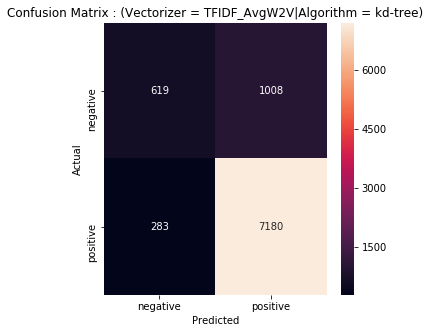

Starttime : 2018-10-27 11:48:03.895476
Endtime   : 2018-10-27 11:49:57.084084


In [68]:
# ============================== KNN with k = optimal_k ===============================================

# training features   = X_train_stdzd_dense
# testing features    = X_test_stdzd_dense
# training classlabel = y_train
# testing  classlabel = y_test

starttime_knn_tfidf_avgw2v = datetime.datetime.now()

# instantiate the k-nn learning model with neighbours k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimised_knn.n_neighbors)

# fitting the model
knn_optimal.fit(X_train_stdzd, y_train)

# predict the response
y_pred = knn_optimal.predict(X_test_stdzd)

# evaluate the model and report the metrics.
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d'
            ,xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title('Confusion Matrix : (Vectorizer = TFIDF_AvgW2V|Algorithm = kd-tree)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

endtime_knn_tfidf_avgw2v = datetime.datetime.now()

print("Starttime : {}".format(starttime_knn_tfidf_avgw2v))
print("Endtime   : {}".format(endtime_knn_tfidf_avgw2v))


### CONCLUSION : 
#### Vectorization Method : TermFrequency-InverseDocumentFrequency Word2Vec (TF-IDF W2V )

#### Algorithm : kd-tree
    . The optimal k in k-nn classifier for the sample (size = 100K) is found to be 9.
    . The confusion matrix of the k-nn classifier when k=9, for the sample (size = 100K) is 
      tabulated below :

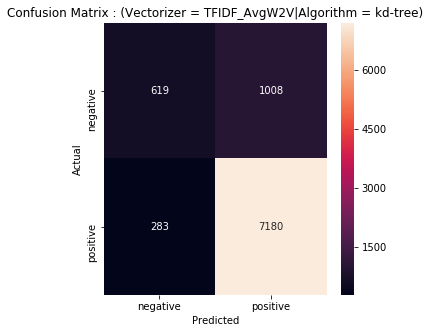

In [4]:
from IPython.display import Image 
Image(filename='D:\Plot\confusionmatrix_tfidf_avgw2v_kdtree.png')

#### Vectorization Method : Average Word2Vec (Avg W2V )

#### Algorithm : kd-tree
    . The optimal k in k-nn classifier for the sample (size = 100K) is found to be 10.
    . The confusion matrix of the k-nn classifier when k=10, for the sample (size = 100K) is
      tabulated below :

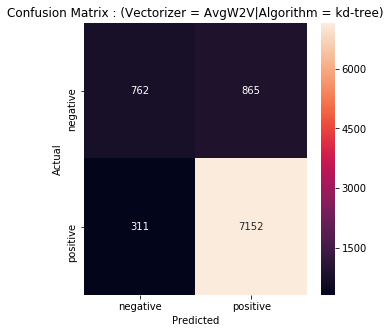

In [3]:
Image(filename='D:\Plot\confusionmatrix_avgw2v_kdtree.png')

#### Vectorization Method : TermFrequency-InverseDocumentFrequency (TF-IDF)

#### Algorithm : kd-tree
    . The optimal k in k-nn classifier for the sample (size = 100K) is found to be 9.
    . The confusion matrix of the k-nn classifier when k=9, for the sample (size = 100K) is
      tabulated below :

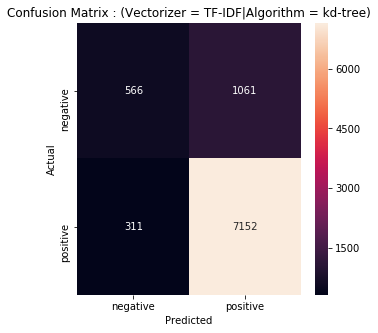

In [5]:
Image(filename='D:\Plot\confusionmatrix_tf-idf_kd_tree.png')

#### Vectorization Method : Bag of Words (Bigram)

#### Algorithm : kd-tree
    . The optimal k in k-nn classifier for the sample (size = 100K) is found to be 9.
    . The confusion matrix of the k-nn classifier when k=9, for the sample (size = 100K) is
      tabulated below :

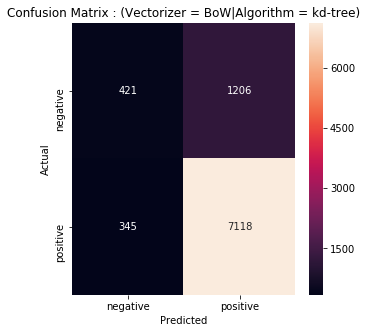

In [6]:
Image(filename='D:\Plot\confusionmatrix_bow_kdtree.png')